<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_Differencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Differencing(차분)

## 1) 차분이란?

* 시계열 (X_t)의 **변화량**을 계산해 추세/단위근(비정상성)을 제거하는 변환.
* 목표: **평균·분산이 시간에 따라 일정**한(약)정상 시계열로 변환 → ARMA/ARIMA 등 선형 모델 적용 가능.


$$\text{1차 차분:}\quad \nabla X_t = X_t - X_{t-1}$$


$$\text{2차 차분:}\quad \nabla^2 X_t = \nabla(\nabla X_t) = X_t - 2X_{t-1} + X_{t-2}$$

$$\text{계절 차분(주기 (s)):}\quad \nabla_s X_t = X_t - X_{t-s}$$


> 직관: 추세가 있는 주가 레벨은 비정상적이지만, **일일 수익률(=차분/로그차분)**은 대체로 정상에 가깝습니다.


## 2) 왜/언제 쓰나?

* **랜덤워크/추세**가 있는 데이터: 1차 차분으로 평균을 0 근처로 안정화.
* **곡률(변화의 변화)**까지 강하게 제거 필요: 2차 차분.
* **뚜렷한 계절성**(예: 월별, 주간): 계절 차분 $(\nabla_s)$ 또는 $(\nabla \nabla_s)$ 조합.
* **ARIMA(p,d,q)**에서 (d)는 비계절 차분 횟수, **SARIMA**의 (D)는 계절 차분 횟수.



## 3) 역차분(Inverse differencing)

예측을 차분 공간에서 만든 뒤 **원 단위(레벨)**로 복원할 때 필요.

* 1차 역차분
  
  $$\widehat{X}*t = X*{t-1} + \widehat{\nabla X_t}$$
  $$\quad\Rightarrow\quad$$
  $$\widehat{X}*{t} = X*{t_0} + \sum_{i=t_0+1}^{t} \widehat{\nabla X_i}$$
  

  * **필요한 초기값**: 시작점 바로 직전의 레벨 $$(X_{t_0})$$.

* 2차 역차분

  $$\nabla X_t = \nabla X_{t-1} + \nabla^2 X_t$$

  $$\widehat{X_t} = X_{t-1} + \widehat{\nabla X_t}$$

  

  * **필요한 초기값**: $(X_{t_0-1}, X_{t_0})$ (레벨 2개).

* 계절 역차분(주기 (s))
  
  $$\widehat{X_t} = X_{t-s} + \widehat{\nabla_s X_t}$$
  

  * **필요 초기값**: $(s)$기간 전 레벨.



## 4) 차분 차수 선택(실무 체크리스트)

1. **시각화**: 원시계열, 이동평균, ACF/PACF로 추세·계절성 확인.
2. **단위근 검정**: ADF(augmented Dickey–Fuller), KPSS 등으로 비정상/정상 판단.
3. **점진적 적용**:

   * 1차 차분 → ADF p-value가 충분히 작아지면 멈춤.
   * 그래도 비정상이면 2차 또는 **계절 차분** 추가.
4. **과도 차분(over-differencing) 방지**:

   * ACF가 **강한 음적 1시차 스파이크**를 보이고 예측력이 떨어지면 과도 차분 신호.
   * 최소 차수로 정상성 달성 권장(통상 (d\le 2, D\le 1)).



## 5) 차분 vs. 다른 변환

* **로그/Box–Cox**: 분산 안정화(이분산 완화).
* **차분**: 평균/추세 제거.
  → 종종 **로그 후 차분**(로그수익률) 조합이 가장 안정적.



## 6) 모델과의 연결

* **ARIMA(p,d,q)**: (d)번 차분한 시계열이 ARMA(p,q)로 적합하다는 가정.
* **SARIMA(p,d,q)(P,D,Q)(_s)**: 비계절 차분 (d) + **계절 차분 (D)**.
* 예측 후에는 **반드시 역차분**으로 원 단위 복원 → 성능 지표(RMSE/MAE)는 **레벨** 기준으로 비교.



## 7) 실무 팁

* **첫 관측 손실**: 1차 차분은 첫 값, 2차는 처음 2개가 사라짐 → 윈도 설계 시 고려.
* **백테스트**: Fixed-origin / Rolling / Expanding 방식에서 **역차분**을 정확히 처리해야 leakage 방지.
* **경계값 준비**: 2차·계절 역차분은 필요한 **초깃값(레벨 2개, s개)**를 미리 저장.



## 8) 예제(이 문서의 코드와 매핑)

* `y` : TSLA 종가(레벨)
* `y_d1 = y.diff()` : 1차 차분
* `y_d2 = y.diff().diff()` : 2차 차분
* `inv_diff_1(d1, last_level)` / `inv_diff_2(d2, x_tm2, x_tm1)` : **경고 없는** 역차분 구현
* `adfuller` : 차분 전후 **정상성(p-value)** 비교



## 9) 자주 하는 질문(FAQ)

**Q1. 1차와 2차 중 무엇을 쓰나?**
A. 1차로 충분히 정상성이면 1차에서 멈추는 것이 보통 더 낫습니다. 2차는 과도차분 위험이 큼.

**Q2. 계절 차분은 언제?**
A. ACF가 **주기 (s)**에서 뚜렷하고, STL/시각화로 계절성 명확할 때 $(\nabla_s)$를 추가.

**Q3. 예측을 레벨로 보고 싶다**
A. 차분 공간에서 예측 후 **역차분**으로 반드시 복원하세요(초기 레벨 보관 필수).

**Q4. 차분 대신 이동평균으로도 되나?**
A. 이동평균은 **평활** 기법이고, 차분은 **변환**입니다. 목적이 다릅니다(정상성 확보엔 차분이 표준).


[*********************100%***********************]  1 of 1 completed


TSLA: 1952 obs | 2018-01-02 ~ 2025-10-07


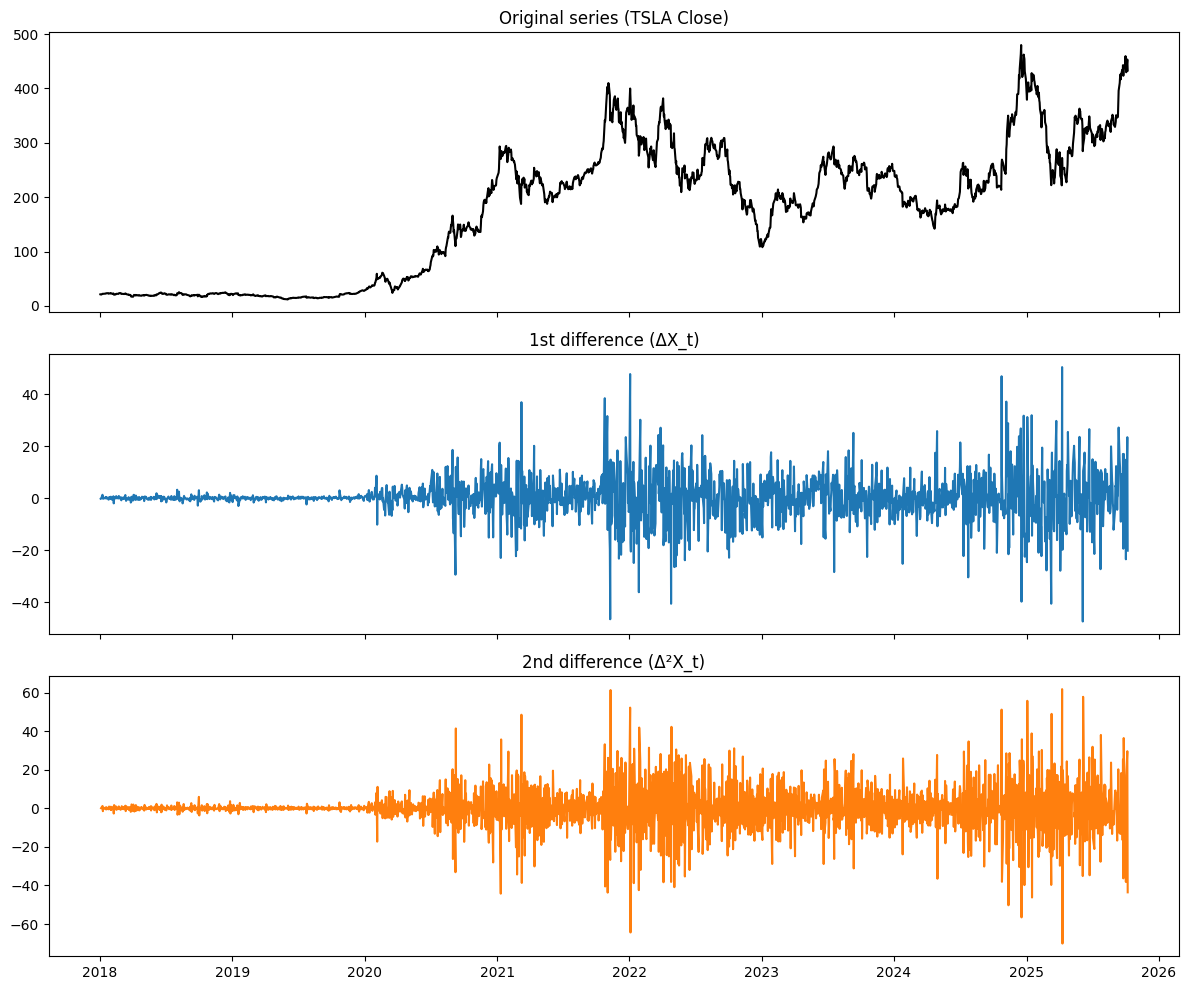

[Inverse-1st] RMSE on last 60 obs: 6.1200
[Inverse-2nd] RMSE on last 60 obs: 338.8859


/tmp/ipython-input-1219603226.py:113: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_tm2, x_tm1 = float(_last2[0]), float(_last2[1])


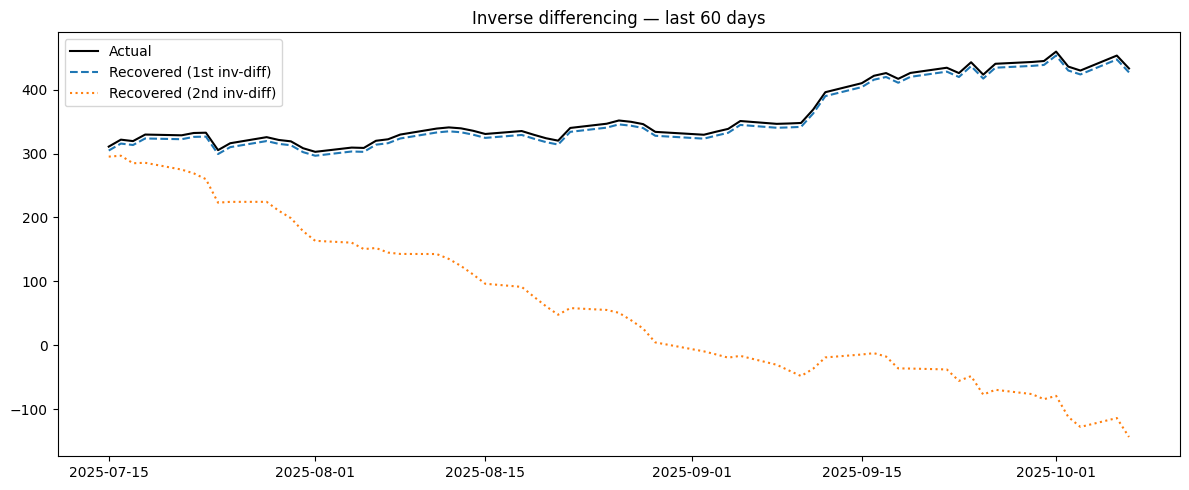

ADF p-value [원시계열(레벨)]: 0.610141
ADF p-value [1차 차분]: 0.000000
ADF p-value [2차 차분]: 0.000000

요약
 - 1차 차분: 추세를 제거해 정상성에 가까워지도록 함 (랜덤워크 → 백색잡음에 근접).
 - 2차 차분: 곡률(변화의 변화)까지 제거, 더 강하게 추세를 평탄화.
 - 역차분: 차분값과 시작값(1차: 직전 레벨 1개, 2차: 직전 레벨 2개)을 이용해 원시계열을 복원.


In [5]:
# =========================================================
# 차분(Differencing) & 역차분(Inverse differencing) 예제
#  - 데이터: TSLA 종가 (yfinance)
#  - 포함: 1차 차분, 2차 차분, 역차분(복원) 함수, ADF 비교, 시각화
# =========================================================

# (필요시)
# %pip -q install yfinance statsmodels

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

plt.rcParams["figure.figsize"] = (12, 5)

# -----------------------------
# 1) 데이터 로드 (TSLA 종가)
# -----------------------------
symbol = "TSLA"
start  = "2018-01-01"
end    = None  # 오늘까지

px = yf.download(symbol, start=start, end=end, auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)

y = px["Close"].copy()
y.name = "TSLA_Close"

print(f"{symbol}: {len(y)} obs | {y.index[0].date()} ~ {y.index[-1].date()}")

# -----------------------------
# 2) Differencing utilities
# -----------------------------
def diff_1(series: pd.Series) -> pd.Series:
    s = series.diff().dropna()
    s.name = f"{series.name}_diff1"
    return s

def diff_2(series: pd.Series) -> pd.Series:
    s = series.diff().diff().dropna()
    s.name = f"{series.name}_diff2"
    return s

def _to_series(x):
    """Accept Series or 1-col DataFrame → Series."""
    if isinstance(x, pd.DataFrame):
        if x.shape[1] != 1:
            raise ValueError("Expect Series or 1-column DataFrame.")
        x = x.iloc[:, 0]
    return x

def inv_diff_1(d1, last_level: float) -> pd.Series:
    """Inverse of 1st difference: X_t = last_level + cumsum(d1)."""
    d1 = _to_series(d1).astype(float)
    rec = last_level + d1.cumsum()
    rec.name = "recovered_from_diff1"
    return rec

def inv_diff_2(d2, x_tm2: float, x_tm1: float) -> pd.Series:
    """
    Inverse of 2nd difference.
      need X_{t-2}=x_tm2, X_{t-1}=x_tm1
      d1_{t-1} = X_{t-1} - X_{t-2}
      d1_t = d1_{t-1} + d2_t
      X_t  = X_{t-1} + d1_t
    """
    d2 = _to_series(d2).astype(float)
    rec_vals = []
    prev2, prev1 = float(x_tm2), float(x_tm1)
    d1_prev = prev1 - prev2
    for _, d2_t in d2.items():
        d1_t = d1_prev + float(d2_t)
        x_t  = prev1 + d1_t
        rec_vals.append(x_t)
        prev2, prev1 = prev1, x_t
        d1_prev = d1_t
    rec = pd.Series(rec_vals, index=d2.index, name="recovered_from_diff2")
    return rec

# -----------------------------
# 3) First/Second differences
# -----------------------------
y_d1 = diff_1(y)
y_d2 = diff_2(y)

fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axes[0].plot(y, color="black");        axes[0].set_title("Original series (TSLA Close)")
axes[1].plot(y_d1, color="tab:blue");  axes[1].set_title("1st difference (ΔX_t)")
axes[2].plot(y_d2, color="tab:orange");axes[2].set_title("2nd difference (Δ²X_t)")
plt.tight_layout(); plt.show()

# -----------------------------
# 4) Inverse differencing (warning-free scalar extraction)
# -----------------------------
N = 60
test_idx = y.index[-N:]

# --- 1st inverse diff ---
# initial level = last level up to (and including) the first test date
base_1 = y.loc[:test_idx[0]].tail(1).to_numpy(dtype=float).item()  # <-- no FutureWarning
d1_last = y.diff().reindex(test_idx).dropna()
y_rec1  = inv_diff_1(d1_last, last_level=base_1)

rmse_1 = float(np.sqrt(mean_squared_error(y.loc[d1_last.index], y_rec1)))
print(f"[Inverse-1st] RMSE on last {len(d1_last)} obs: {rmse_1:,.4f}")

# --- 2nd inverse diff ---
# need two initial levels up to the first test date
_last2 = y.loc[:test_idx[0]].tail(2).to_numpy(dtype=float)         # <-- safe extraction
x_tm2, x_tm1 = float(_last2[0]), float(_last2[1])

d2_last = y.diff().diff().reindex(test_idx).dropna()
y_rec2  = inv_diff_2(d2_last, x_tm2=x_tm2, x_tm1=x_tm1)

rmse_2 = float(np.sqrt(mean_squared_error(y.loc[d2_last.index], y_rec2)))
print(f"[Inverse-2nd] RMSE on last {len(d2_last)} obs: {rmse_2:,.4f}")

# Overlay
plt.figure(figsize=(12,5))
plt.plot(y.loc[test_idx], label="Actual", color="black")
plt.plot(y_rec1, label="Recovered (1st inv-diff)", linestyle="--")
plt.plot(y_rec2, label="Recovered (2nd inv-diff)", linestyle=":")
plt.title(f"Inverse differencing — last {N} days")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# 6) 정상성(ADF) 간단 비교
#   - 차분 전후 p-value 비교 (작을수록 '정상성'으로 기각되기 쉬움)
# -----------------------------
def adf_p(series, name):
    p = adfuller(series.dropna(), autolag="AIC")[1]
    print(f"ADF p-value [{name}]: {p:.6f}")
    return p

p_raw = adf_p(y,    "원시계열(레벨)")
p_d1  = adf_p(y_d1, "1차 차분")
p_d2  = adf_p(y_d2, "2차 차분")

# -----------------------------
# 7) 요약 메모
# -----------------------------
print("\n요약")
print(" - 1차 차분: 추세를 제거해 정상성에 가까워지도록 함 (랜덤워크 → 백색잡음에 근접).")
print(" - 2차 차분: 곡률(변화의 변화)까지 제거, 더 강하게 추세를 평탄화.")
print(" - 역차분: 차분값과 시작값(1차: 직전 레벨 1개, 2차: 직전 레벨 2개)을 이용해 원시계열을 복원.")
